## **Importing Neccesary Libraries**

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import  CountVectorizer

import re
import string
import nltk
import spacy
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Web Scraping

In [ ]:
URL = "https://www.amazon.in/product-reviews/B089MTJVLD/ref=cm_cr_arp_d_viewopt_sr?ie=UTF8&filterByStar=all_stars&reviewerType=all_reviews&pageNumber="                  

headers = ({'User-Agent':
             'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \
             AppleWebKit/537.36 (KHTML, like Gecko) \
             Chrome/90.0.4430.212 Safari/537.36',
             'Accept-Language': 'en-US, en;q=0.5'})
resp=""
finalResp = ""
for i in range(1,500):
    page = URL+str(i)
    #print(productUrl)
    resp = requests.get(page, headers=headers)
    finalResp+=resp.text
    resp = ""
def get_review_stars(soup_obj: BeautifulSoup) -> str:
    try:
        review_str = soup_obj.find('a', {"class": "a-link-normal"}).get_text()
        review_str = review_str.lower()
        review_str = review_str.replace(" out of 5 stars", "")
        return review_str
    except Exception as e:
        return 'no_stars'
        print(e)
def get_review_body(soup_obj: BeautifulSoup) -> str:
    try:
        review_body = soup_obj.find('span', 
            {"class": "a-size-base review-text review-text-content"}
        ).get_text().strip()
        return review_body
    except Exception as e:
        return 'no_body'
        print(e)
def get_review_components(soup_obj: BeautifulSoup) -> dict:
    return {
        'stars':get_review_stars(soup_obj) , 
        'body': get_review_body(soup_obj), 
    }
soup = BeautifulSoup(finalResp, "html.parser")
reviews = soup.find_all("div", {"class": "a-section review aok-relative"})

records = [get_review_components(rev) for rev in reviews]
dataset = pd.DataFrame(records)
dataset

,stars,body
0,1.0,Battery Issue.... Phone is Heating during Char...
1,2.0,"Iam OnePlus user since 4 years, I exchange my ..."
2,5.0,After 5 days of usage writing this review.1. B...
3,3.0,Writing after 4 Days of use1. Heating Issues -...
4,1.0,OnePlus 9r is best of both world that you get ...
...,...,...
4226,3.0,Not great one Plus 7 was better
4227,5.0,It's too goodThe camera quality is so original...
4228,1.0,Not worth it's like vivo phone
4229,5.0,Camera 4.5/5Battery 5/5Built 5/5Display 5/5Aud...


In [ ]:
dataset.to_csv('Oneplusfinal.csv')

## **Importing Data**

In [ ]:
data = pd.read_csv('Oneplusfinal.csv')
data

,Unnamed: 0,stars,body
0,0,1.0,Battery Issue.... Phone is Heating during Char...
1,1,2.0,"Iam OnePlus user since 4 years, I exchange my ..."
2,2,5.0,After 5 days of usage writing this review.1. B...
3,3,3.0,Writing after 4 Days of use1. Heating Issues -...
4,4,1.0,OnePlus 9r is best of both world that you get ...
...,...,...,...
4226,4226,3.0,Not great one Plus 7 was better
4227,4227,5.0,It's too goodThe camera quality is so original...
4228,4228,1.0,Not worth it's like vivo phone
4229,4229,5.0,Camera 4.5/5Battery 5/5Built 5/5Display 5/5Aud...


In [ ]:
data.drop(labels = ['Unnamed: 0','stars'] , axis = 1,inplace = True)
data

,body
0,Battery Issue.... Phone is Heating during Char...
1,"Iam OnePlus user since 4 years, I exchange my ..."
2,After 5 days of usage writing this review.1. B...
3,Writing after 4 Days of use1. Heating Issues -...
4,OnePlus 9r is best of both world that you get ...
...,...
4226,Not great one Plus 7 was better
4227,It's too goodThe camera quality is so original...
4228,Not worth it's like vivo phone
4229,Camera 4.5/5Battery 5/5Built 5/5Display 5/5Aud...


In [ ]:
data.dtypes

body    object
dtype: object

## **Text Preprocessing**

In [ ]:
data=[str(Text).strip() for Text in data.body] # remove both the leading and the trailing characters
data=[Text for Text in data] # removes empty strings, because they are considered in Python as False

In [ ]:
sent_df=pd.DataFrame(data,columns=['sentence'])
sent_df

,sentence
0,Battery Issue.... Phone is Heating during Char...
1,"Iam OnePlus user since 4 years, I exchange my ..."
2,After 5 days of usage writing this review.1. B...
3,Writing after 4 Days of use1. Heating Issues -...
4,OnePlus 9r is best of both world that you get ...
...,...
4226,Not great one Plus 7 was better
4227,It's too goodThe camera quality is so original...
4228,Not worth it's like vivo phone
4229,Camera 4.5/5Battery 5/5Built 5/5Display 5/5Aud...


In [ ]:
stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        text = [word.lower() for word in text]
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)
#clean the review
from string import punctuation
sent_df["sentence"] = sent_df["sentence"].apply(text_cleaning)

In [ ]:
sent_df

,sentence
0,battery issue phone heating charging during ru...
1,iam oneplus user since year i exchange one plu...
2,after day usage writing review best camera qua...
3,writing day use1 heating issue start noticing ...
4,oneplus 9r best world get samsung apple i woul...
...,...
4226,not great one plus better
4227,it goodthe camera quality original look like a...
4228,not worth like vivo phone
4229,camera 5battery 5built 5display 5audio speaker...


In [ ]:
sentence = [sentence for sentence in sent_df['sentence']]
sentence

['battery issue phone heating charging during running application',
 'iam oneplus user since year i exchange one plus pro mobile oneplus r not expected from one plus quality good look like cheep mobile camera quality also good one plus pro superb mobile totally iam disappointed 9r',
 'after day usage writing review best camera quality price2 snapdragon best speed 120hz display best3 65w charger take min charge best4 fluid amoled display awesome smoothness best5 lake blue colour simply awesome issues1 facing lite heating issue found bug informed oneplus customer service turn call recording call indicates opponent also recording call they told correct next update hope cleared sure i give mobile',
 'writing day use1 heating issue start noticing first use2 battery charge min also drain fast need charge twice day using whatsapp browsing calling camera not good le expected think twice buying camera enthusiastic smooth 120hz 60hz condition work well i found smooth use open apps5 snap processo

In [ ]:
pip install afinn

     |████████████████████████████████| 52 kB 1.2 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=4b552cc3e46140097ad1841ffc19405766ec70134fb3fc8f6c2a0c7ff212b1d0
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [ ]:

#importing necessary libraries
from afinn import Afinn
import pandas as pd
afn = Afinn()

In [ ]:
scores = [afn.score(article) for article in sentence]
sentiment = ['positive' if score > 0
                          else 'negative'
                                  for score in scores]
     
# dataframe creation
sent_df = pd.DataFrame()
sent_df['sentence'] = sentence
sent_df['sentiment_value'] = scores
sent_df['sentiments'] = sentiment
print(sent_df)

                                               sentence  sentiment_value  \
0     battery issue phone heating charging during ru...              0.0   
1     iam oneplus user since year i exchange one plu...             15.0   
2     after day usage writing review best camera qua...             19.0   
3     writing day use1 heating issue start noticing ...              8.0   
4     oneplus 9r best world get samsung apple i woul...            -11.0   
...                                                 ...              ...   
4226                          not great one plus better              5.0   
4227  it goodthe camera quality original look like a...             14.0   
4228                          not worth like vivo phone              4.0   
4229  camera 5battery 5built 5display 5audio speaker...              5.0   
4230                                              bueno              0.0   

     sentiments  
0      negative  
1      positive  
2      positive  
3      positive

## **Word Cloud**

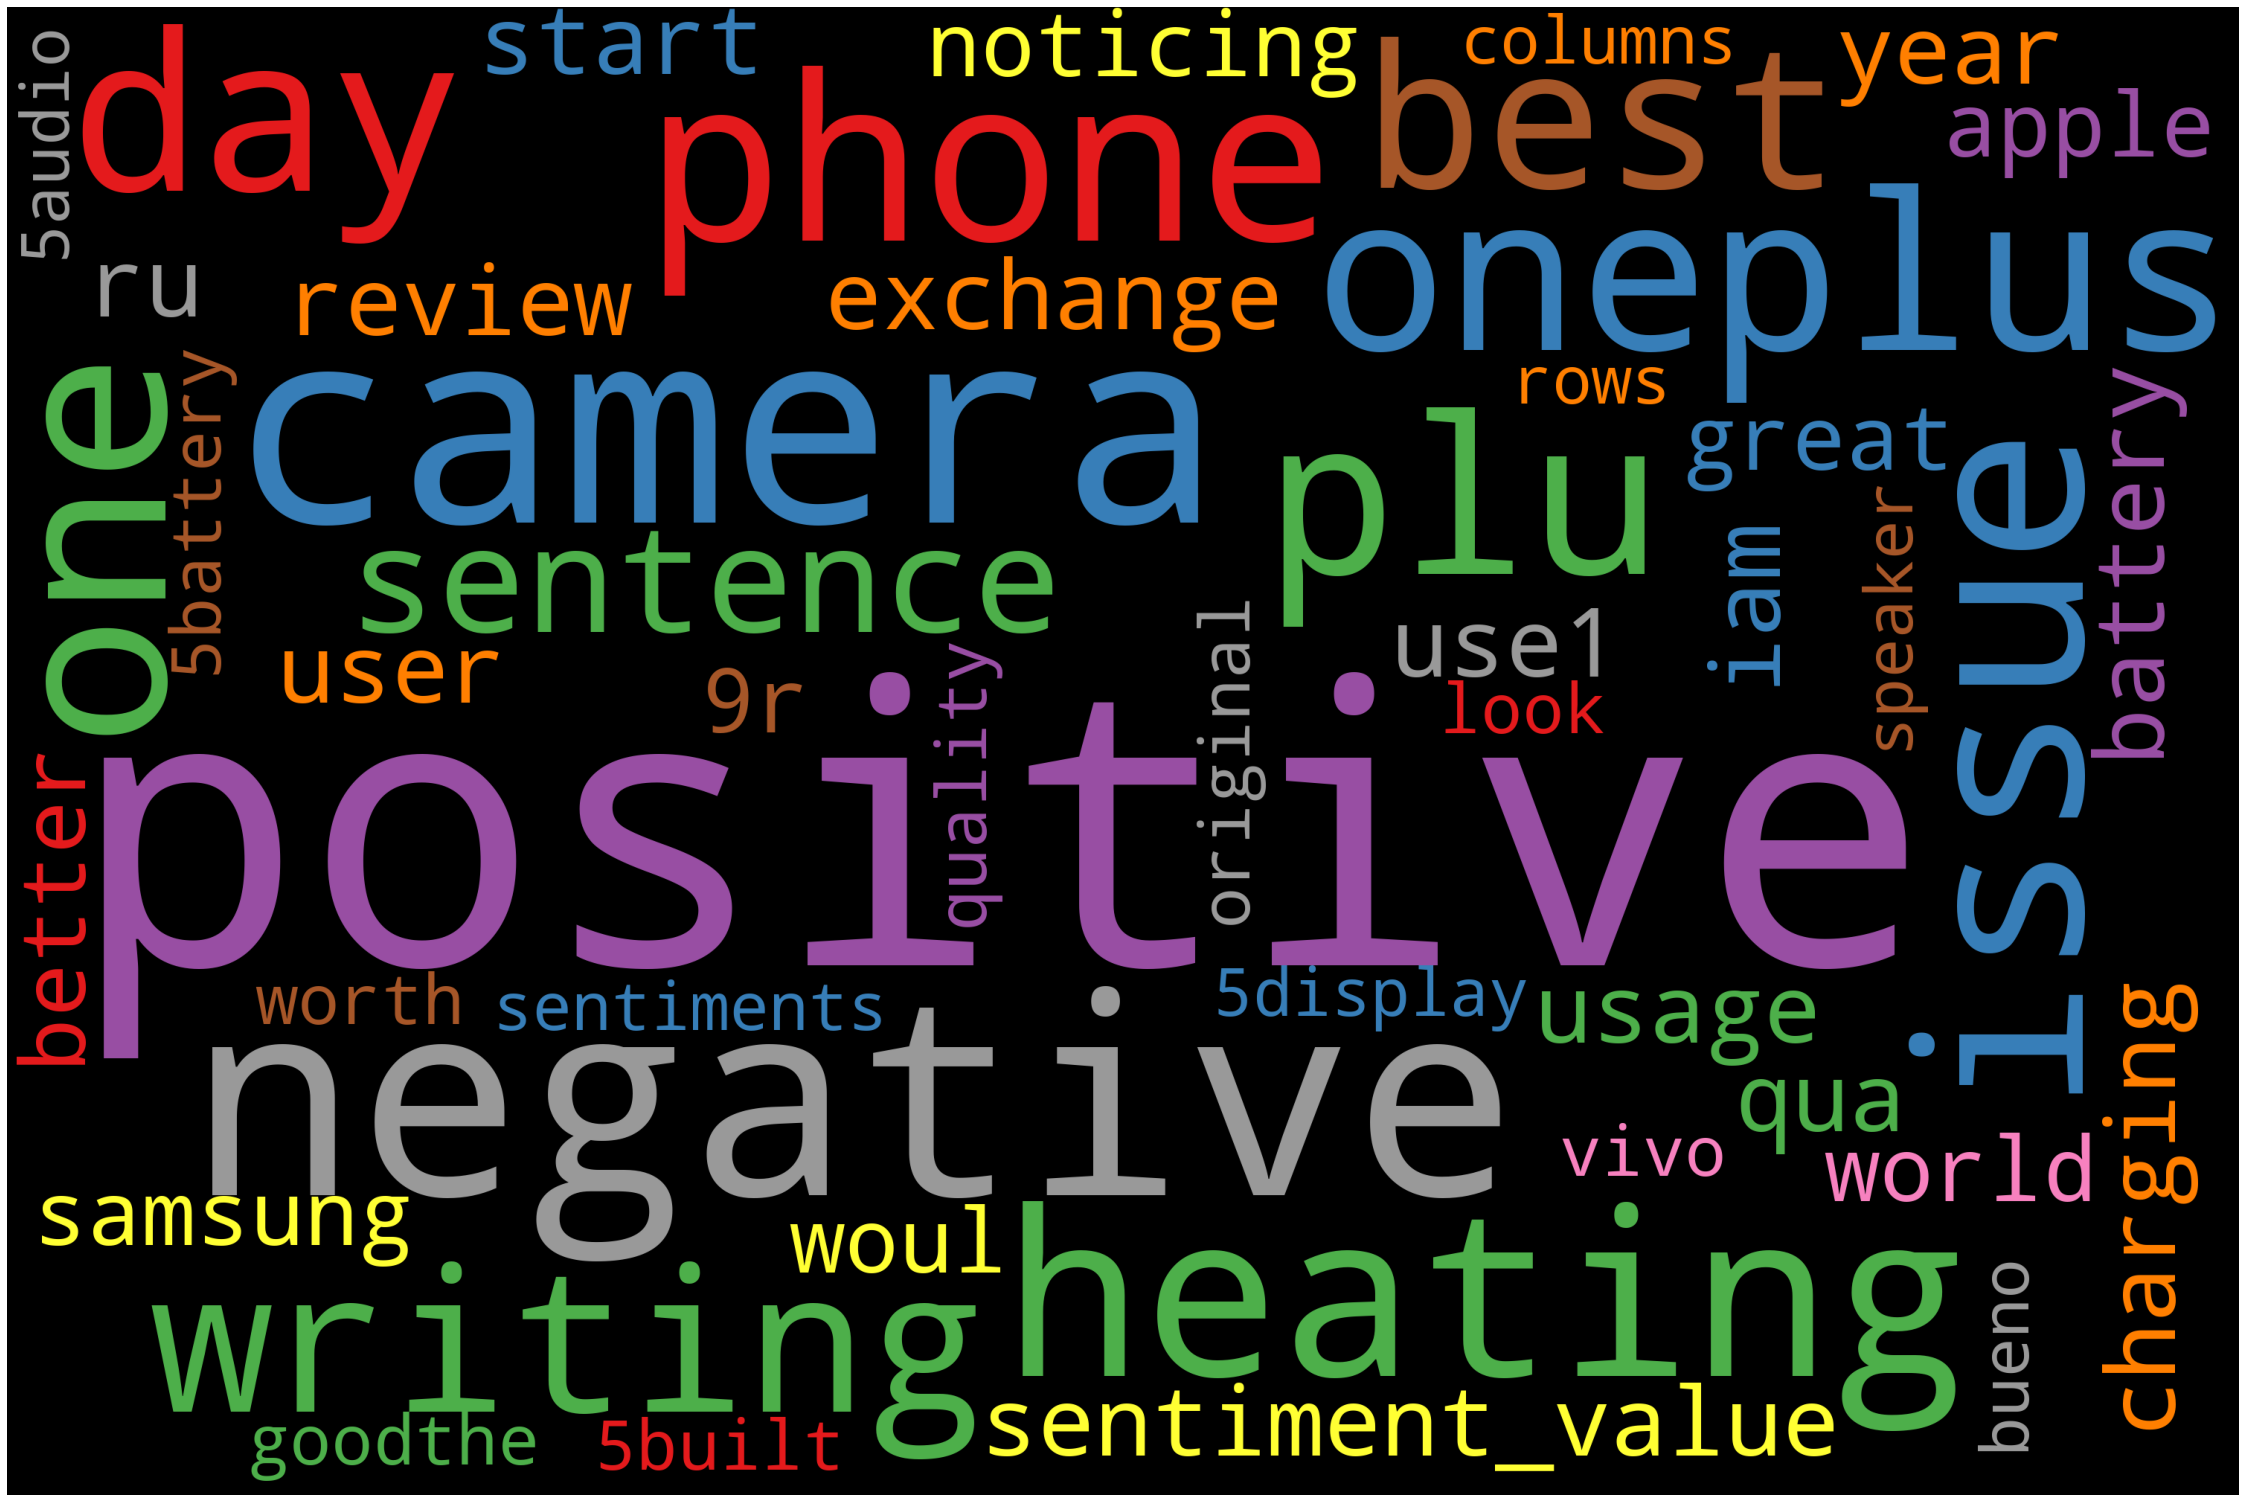

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis('off')

# Generate Word Cloud

STOPWORDS.add('pron')
STOPWORDS.add('rt')
STOPWORDS.add('yeah')
wordcloud=WordCloud(width=3000,height=2000,background_color='black',max_words=50,
                   colormap='Set1',stopwords=STOPWORDS).generate(str(sent_df))
plot_cloud(wordcloud)

## **Creating Affinity Values**

In [ ]:
sent_df.sort_values(by='sentiment_value')

,sentence,sentiment_value,sentiments
1859,worst product heating continuously battery pro...,-17.0,negative
3576,why amazon pay compensation customer mistake s...,-14.0,negative
451,defective battery i purchased phone 13th sep i...,-14.0,negative
3640,i purchased oneplus 9r last month i much disap...,-14.0,negative
312,after month use oneplus 9r writing review1 i r...,-13.0,negative
...,...,...,...
225,i bought 9r samsung galaxy s20 fe 5g stock i n...,45.0,positive
106,will mainly comparing iqoo legend samsung m51 ...,50.0,positive
115,reason chosen flagship sum point proceed 9r ov...,50.0,positive
178,i using phone day long amazing phone if love t...,50.0,positive


In [ ]:
# Sentiment score of the whole review
sent_df['sentiment_value'].describe()

count    4231.000000
mean        3.603876
std         6.014445
min       -17.000000
25%         0.000000
50%         3.000000
75%         5.000000
max        54.000000
Name: sentiment_value, dtype: float64

In [ ]:
# negative sentiment score of the whole review
sent_df[sent_df['sentiment_value']<=0]

,sentence,sentiment_value,sentiments
0,battery issue phone heating charging during ru...,0.0,negative
4,oneplus 9r best world get samsung apple i woul...,-11.0,negative
5,worst phone one plusheating issue yesbattery d...,-10.0,negative
7,first hearing every time i use camera play gam...,-5.0,negative
12,from one plus 3then one plus 6and now one plus...,0.0,negative
...,...,...,...
4217,just go if concerned heating already update wa...,-5.0,negative
4219,i recently bouth mobile phone everyday i suffe...,-7.0,negative
4224,it average phone oneplus could given bit price...,0.0,negative
4225,it average mobile oneplus brand name nothing s...,0.0,negative


In [ ]:
# positive sentiment score of the whole review
sent_df[sent_df['sentiment_value']>0]

,sentence,sentiment_value,sentiments
1,iam oneplus user since year i exchange one plu...,15.0,positive
2,after day usage writing review best camera qua...,19.0,positive
3,writing day use1 heating issue start noticing ...,8.0,positive
6,i writing using couple day i got carbon black ...,24.0,positive
8,i recieved new phone yesterday since i started...,4.0,positive
...,...,...,...
4223,been two week phone i purchased 12gb 256gb ver...,6.0,positive
4226,not great one plus better,5.0,positive
4227,it goodthe camera quality original look like a...,14.0,positive
4228,not worth like vivo phone,4.0,positive


In [ ]:
def sentiments(sentiment_value):
    if (sentiment_value >0):
        return "Positive"
    #elif (sentiment_value == 0):
        #return "Neutral"
    elif (sentiment_value <=0):
        return "Negative"
# Add sentiments to the data
sent_df["Sentiment"] = sent_df["sentiment_value"].apply(sentiments)
sent_df["Sentiment"][:20]

0     Negative
1     Positive
2     Positive
3     Positive
4     Negative
5     Negative
6     Positive
7     Negative
8     Positive
9     Positive
10    Positive
11    Positive
12    Negative
13    Positive
14    Negative
15    Positive
16    Negative
17    Negative
18    Negative
19    Positive
Name: Sentiment, dtype: object

In [ ]:
sent_df

,sentence,sentiment_value,sentiments,Sentiment
0,battery issue phone heating charging during ru...,0.0,negative,Negative
1,iam oneplus user since year i exchange one plu...,15.0,positive,Positive
2,after day usage writing review best camera qua...,19.0,positive,Positive
3,writing day use1 heating issue start noticing ...,8.0,positive,Positive
4,oneplus 9r best world get samsung apple i woul...,-11.0,negative,Negative
...,...,...,...,...
4226,not great one plus better,5.0,positive,Positive
4227,it goodthe camera quality original look like a...,14.0,positive,Positive
4228,not worth like vivo phone,4.0,positive,Positive
4229,camera 5battery 5built 5display 5audio speaker...,5.0,positive,Positive


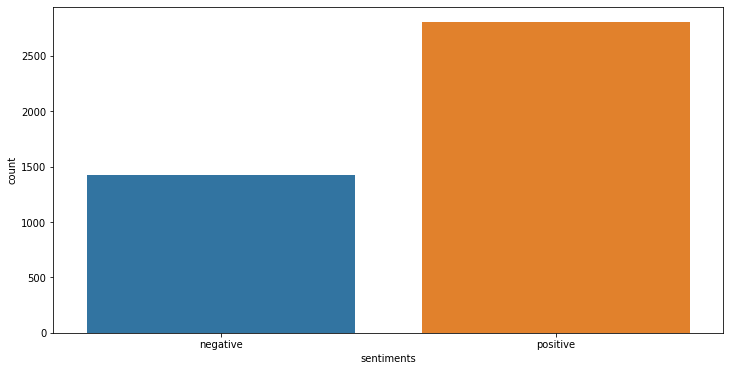

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize = (12,6))
sns.countplot(sent_df['sentiments'])
plt.show()

In [ ]:
dataset = sent_df[['sentence','sentiments']]
dataset

,sentence,sentiments
0,battery issue phone heating charging during ru...,negative
1,iam oneplus user since year i exchange one plu...,positive
2,after day usage writing review best camera qua...,positive
3,writing day use1 heating issue start noticing ...,positive
4,oneplus 9r best world get samsung apple i woul...,negative
...,...,...
4226,not great one plus better,positive
4227,it goodthe camera quality original look like a...,positive
4228,not worth like vivo phone,positive
4229,camera 5battery 5built 5display 5audio speaker...,positive


In [ ]:
dataset

,sentence,sentiments
0,battery issue phone heating charging during ru...,negative
1,iam oneplus user since year i exchange one plu...,positive
2,after day usage writing review best camera qua...,positive
3,writing day use1 heating issue start noticing ...,positive
4,oneplus 9r best world get samsung apple i woul...,negative
...,...,...
4226,not great one plus better,positive
4227,it goodthe camera quality original look like a...,positive
4228,not worth like vivo phone,positive
4229,camera 5battery 5built 5display 5audio speaker...,positive


## **Model Building**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataset,
                                           dataset["sentiments"]): 
    strat_train = dataset.reindex(train_index)
    strat_test = dataset.reindex(test_index)

In [ ]:
len(strat_train)

3384

In [ ]:
len(strat_test)

847

In [ ]:
strat_test["sentiments"].value_counts()/len(strat_test)

positive    0.662338
negative    0.337662
Name: sentiments, dtype: float64

In [ ]:
# Prepare data
X_train = strat_train["sentence"]
X_train_targetSentiment = strat_train["sentiments"]
X_test = strat_test["sentence"]
X_test_targetSentiment = strat_test["sentiments"]
print(len(X_train), len(X_test))

3384 847


In [ ]:
# Text preprocessing and occurance counting
from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train) 
X_train_counts.shape

(3384, 5569)

In [ ]:
# Text preprocessing and occurance counting
from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer()
X_test_counts = count_vect.fit_transform(X_test) 
X_test_counts.shape

(847, 2504)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(3384, 5569)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_test_tfidf.shape

(847, 2504)

## **Model Training**

####**1.Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_multiNB_pipe = MultinomialNB()
clf_multiNB_pipe.fit(X_train_tfidf, X_train_targetSentiment)

MultinomialNB()

In [ ]:
import numpy as np
predictedMultiNB = clf_multiNB_pipe.predict(X_test_tfidf )
np.mean(predictedMultiNB == X_test_targetSentiment)

ValueError: ignored

####**2.Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), 
                            ("tfidf", TfidfTransformer()), 
                            ("clf_logReg", LogisticRegression())])
clf_logReg_pipe.fit(X_train, X_train_targetSentiment)

import numpy as np
predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == X_test_targetSentiment)

0.9079102715466352

####**3.Support Vector Machine**

In [ ]:
from sklearn.svm import LinearSVC
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), 
                               ("tfidf", TfidfTransformer()),
                               ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, X_train_targetSentiment)

predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == X_test_targetSentiment)

0.9208972845336482

####**4.Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf_decisionTree_pipe = Pipeline([("vect", CountVectorizer()), 
                                  ("tfidf", TfidfTransformer()), 
                                  ("clf_decisionTree", DecisionTreeClassifier())
                                 ])
clf_decisionTree_pipe.fit(X_train, X_train_targetSentiment)

predictedDecisionTree = clf_decisionTree_pipe.predict(X_test)
np.mean(predictedDecisionTree == X_test_targetSentiment)

0.9149940968122786

####**5.Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_randomForest_pipe = Pipeline([("vect", CountVectorizer()), 
                                  ("tfidf", TfidfTransformer()), 
                                  ("clf_randomForest", RandomForestClassifier())
                                 ])
clf_randomForest_pipe.fit(X_train, X_train_targetSentiment)

predictedRandomForest = clf_randomForest_pipe.predict(X_test)
np.mean(predictedRandomForest == X_test_targetSentiment)

0.9197166469893743

**Above all the algorithm support vector machine gives good accuracy**

## **Model Evaluation**

In [ ]:

from sklearn.metrics import accuracy_score

print('Accuracy Score of Naive Bayes         :',accuracy_score(predictedMultiNB,X_test_targetSentiment))
print('Accuracy Score of Logistic Regression :',accuracy_score(predictedLogReg,X_test_targetSentiment))
print('Accuracy Score of SVM                 :',accuracy_score(predictedLinearSVC,X_test_targetSentiment))
print('Accuracy Score of Decision Tree       :',accuracy_score(predictedDecisionTree,X_test_targetSentiment))
print('Accuracy Score of Random Forest       :',accuracy_score(predictedRandomForest,X_test_targetSentiment))

Accuracy Score of Naive Bayes         : 0.7544273907910272
Accuracy Score of Logistic Regression : 0.9079102715466352
Accuracy Score of SVM                 : 0.9208972845336482
Accuracy Score of Decision Tree       : 0.9149940968122786
Accuracy Score of Random Forest       : 0.9197166469893743


## **Sample Testing using SVM**

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],    
             'tfidf__use_idf': (True, False), 
             } 
gs_clf_LinearSVC_pipe = GridSearchCV(clf_linearSVC_pipe, parameters, n_jobs=-1)
gs_clf_LinearSVC_pipe = gs_clf_LinearSVC_pipe.fit(X_train, 
                                                  X_train_targetSentiment)
new_text = ["this mobile is worst", 
            "I hate this product", 
            " Alright, most disappointing Mi Phone yet of over 15 xiaomi phones I've bought, including the Mi 3.",
            "Very bad experience, i am going to return it, i am facing touch issue very much",
            "The only issue I am facing is over heating on normal use. Not satisfied. Thinking about replacing",
            "Plastic quality is OK, Mettle parts seem to be very thin but the point is, it still works fine, if used with care I think that should not be a problem.",
            " IT DOES HAVE AUTO CUTOFF and I used it."] 

predictedLinearSVC = clf_linearSVC_pipe.predict(new_text)

predictedLinearSVC

array(['negative', 'negative', 'negative', 'negative', 'positive',
       'positive', 'negative'], dtype=object)

## **Model Deployement**

In [ ]:
#Save Model
import joblib 

joblib.dump(clf_linearSVC_pipe, 'Review_model.pkl')

['Review_model.pkl']

In [ ]:
#save Vectorizer
joblib.dump(count_vect,'count_vectorizer.pkl')

['count_vectorizer.pkl']